In [1]:
import torch.nn.functional as F
import torch
from torch import Tensor
from torchvision.transforms.functional import crop, resize

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
from cfa import sparse_ones, rgb_to_cfa, colorize_cfa

In [3]:
import os

def findAllFiles(path):
    res = []
    path, folders, files = next(os.walk(path))
    if folders:
        for f in folders:
            res.extend(findAllFiles(os.path.join(path, f)))
    res.extend([os.path.join(path, f) for f in files])
    return res

In [4]:
raw_folder = "../../raw-instinct/16bitRAW"
classes    = os.listdir(raw_folder)
raw_data   = [(c,[np.load(f).astype(np.int32)
                  for f in findAllFiles(os.path.join(raw_folder, c))]) 
              for c in classes]

### Chrominance visualisation

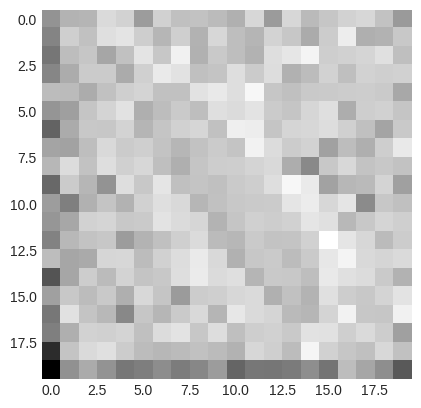

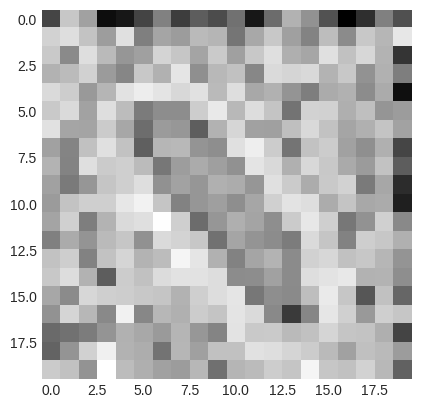

0.5234518647193909 0.4057725667953491


In [5]:
def chroma(mat):
    bayer_k = Tensor(sparse_ones((4,1,2,2), [(0,0,0,1),(1,0,0,0),(2,0,1,0),(3,0,1,1)]))
    rgb_k   = Tensor(sparse_ones((4,3,2,2), [(0,0,0,1),(1,1,0,0),(2,2,1,0),(3,1,1,1)]))
    cr_k    = Tensor(sparse_ones((2,3,2,2), [(1,1,1,0),(0,0,1,0)]))
    cb_k    = Tensor(sparse_ones((2,3,2,2), [(1,1,0,1),(0,2,0,1)]))
    g_int_k = Tensor(sparse_ones((3,3,3,3), [(1,1,0,1),(1,1,1,0),(1,1,1,2),(1,1,2,1)]) * 0.25)
    
    tensor = torch.Tensor(mat).unsqueeze(0)

    # CFA 1d -> RGB CFA 3d representation
    conv   = F.conv2d(          tensor, stride=2, weight=bayer_k, padding=1)
    rgb    = F.conv_transpose2d(conv,   stride=2, weight=rgb_k,   padding=1)

    # Interpolate green channel
    bi_g   = F.conv2d(          rgb,              weight=g_int_k, padding=1) + rgb

    # Extract green/red and green/blue
    cr_l   = F.conv2d(          bi_g,   stride=2, weight=cr_k)
    cb_l   = F.conv2d(          bi_g,   stride=2, weight=cb_k)

    # Calculate chrominance as two maps
    cr     = (cr_l[0] / cr_l[1])
    cb     = (cb_l[0] / cb_l[1])

    return cr, cb
    

def chromaMean(mat):
    cr, cb = chroma(mat)
    return torch.mean(cr).item(), torch.mean(cb).item()


test = raw_data[0][1][0]

cr, cb = chroma(test)

plt.style.use("seaborn-v0_8-dark")
plt.imshow((cr / cr.max()))
plt.show()
plt.imshow((cb / cb.max()))
plt.show()
print(torch.mean(cr).item(), torch.mean(cb).item())

In [6]:
raw_chroma = [(c, np.array([chromaMean(m) for m in lst])) for (c, lst) in raw_data]

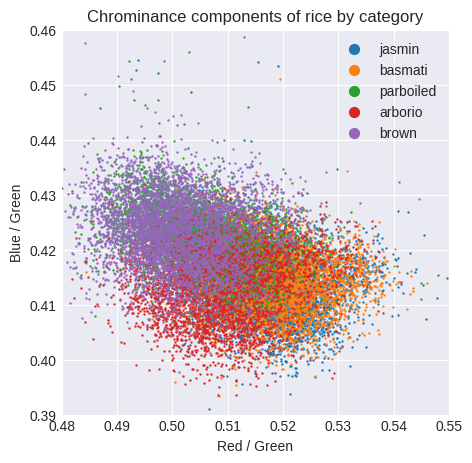

In [41]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("Chrominance components of rice by category")
ax.set_ylim([0.39, 0.46])
ax.set_xlim([0.48,  0.55])
ax.set_xlabel("Red / Green")
ax.set_ylabel("Blue / Green")
for (c, lst) in raw_chroma:
    ax.scatter(*lst.T, s=0.5, label=c)

ax.legend(markerscale=10)

### Value visualisation
Notice that the Arborio rice seperate out from the rest.

In [8]:
raw_min_maxs = [(c, np.array([[np.percentile(np.array(m), 10), 
                               np.percentile(np.array(m), 90)] for m in lst])) for (c, lst) in raw_data]

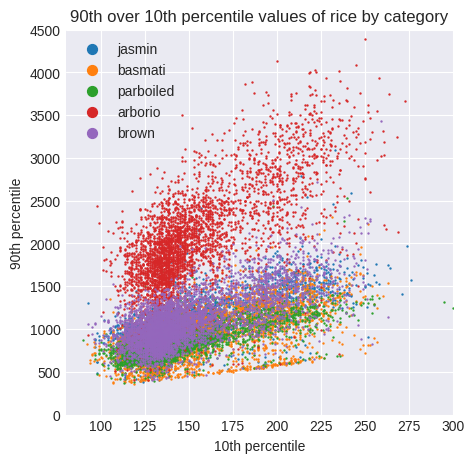

In [38]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("90th over 10th percentile values of rice by category")
ax.set_ylim([0, 4500])
ax.set_xlim([80, 300])
ax.set_xlabel("10th percentile")
ax.set_ylabel("90th percentile")
for (c, lst) in raw_min_maxs:
    ax.scatter(*lst.T, s=0.5, label=c)

ax.legend(markerscale=10)

### DNG dataset packing 

In [10]:
import math
import dng

flatten = lambda matrix: [item for row in matrix for item in row]

dataset     = raw_data
layout      = [(c, len(imgs)) for (c, imgs) in raw_data]
imgs        = flatten([imgs for (_, imgs) in dataset])
n_cells     = sum([l for (_, l) in layout])
cell_shape  = (40,40)
padding     = (12,12)
cell_w      = (padding[1]*2 + cell_shape[1])
dng_cells_w = math.ceil(math.sqrt(len(imgs)))
dng_px_w    = dng_cells_w * cell_w

res = np.zeros((dng_px_w, dng_px_w), dtype=np.uint16)

for n, img in enumerate(imgs):
    x = ((n % dng_cells_w)  * cell_w) + padding[0]
    y = ((n // dng_cells_w) * cell_w) + padding[1]
    res[x:x+cell_shape[0], y:y+cell_shape[1]] = img * (2**15 / img.max())

dng.saveFile(res, "rice")

#### Color test image

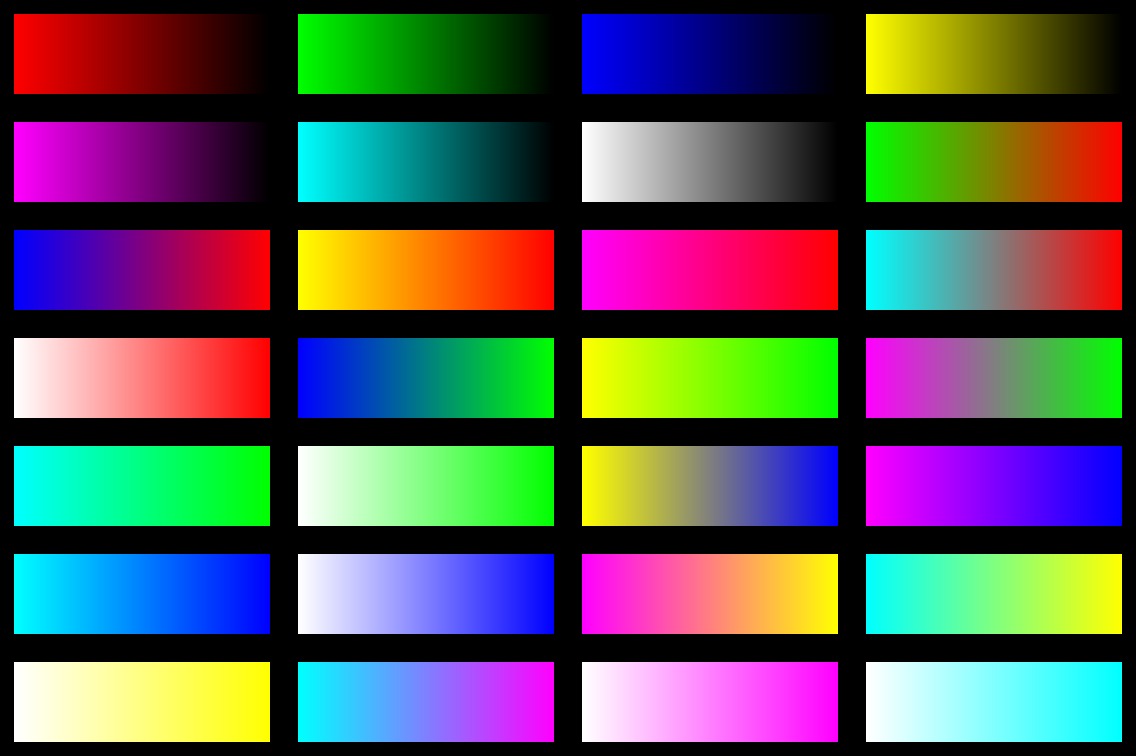

In [121]:
from itertools import chain, combinations, product

# From itertools documentation
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

sweeps = list(combinations(powerset([0,1,2]), 2))

grey   = np.array([128,128,128])

dtype, dt_max, dt_range = np.uint16, 2**16 - 1, 256

pad    = (14,14)
size   = (80, 256)
y_step = pad[1] * 2 + size[1]
x_step = pad[0] * 2 + size[0]

ct_arr = np.zeros((x_step, y_step * len(sweeps), 3), dtype=dtype)

sweep_in  = np.pad(np.broadcast_to(np.linspace(0, dt_max, size[1], dtype=dtype), size), pad)
sweep_out = np.pad(np.broadcast_to(np.linspace(dt_max, 0, size[1], dtype=dtype), size), pad)

for i, (sweep_from, sweep_to) in enumerate(sweeps):
    for c in sweep_from:
        ct_arr[:, i*y_step:(i+1)*y_step, c] += sweep_in
    for c in sweep_to:
        ct_arr[:, i*y_step:(i+1)*y_step, c] += sweep_out

ct_img = np.zeros((x_step * 7, y_step * 4, 3), dtype=dtype)

for i in range(7):
    for j in range(4):
        n = i*4 + j
        ct_img[i*x_step:(i+1)*x_step, j*y_step:(j+1)*y_step] = ct_arr[:, n*y_step:(n+1)*y_step]
    
        
display(Image.fromarray(np.array(ct_img, dtype=np.uint8)))

#### DNG Roundtrip convertion loss

In [100]:
rgb_kf  = sparse_ones((3,2,2), [(0,0,1),(1,0,0),(2,1,0),(1,1,1)])

dng.saveFile(rgb_to_cfa(ct_img, rgb_kf), "ct")

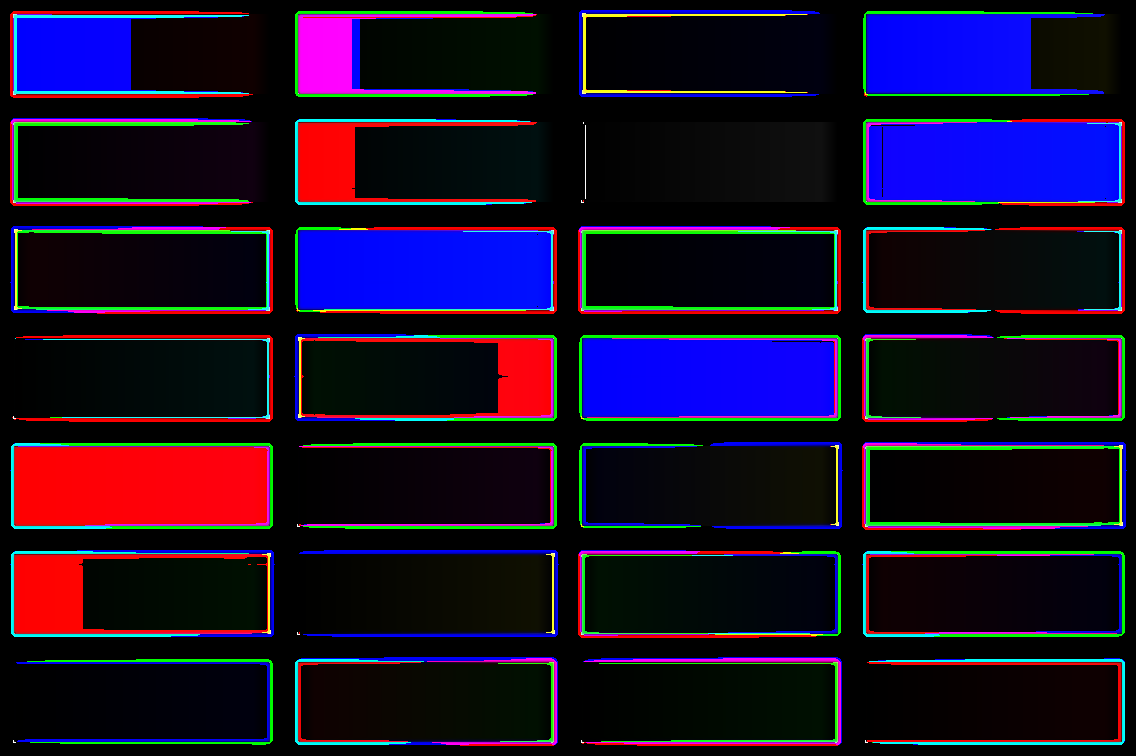

In [117]:
img_ct_roundtrip = np.array(Image.open("ct-ahd-3step-color-supress.png"), dtype=np.uint16)

img_ct_diff = (ct_img - img_ct_roundtrip)
display(Image.fromarray((np.abs(img_ct_diff)).astype("uint8")))

#### Noise

(756, 1136, 3)


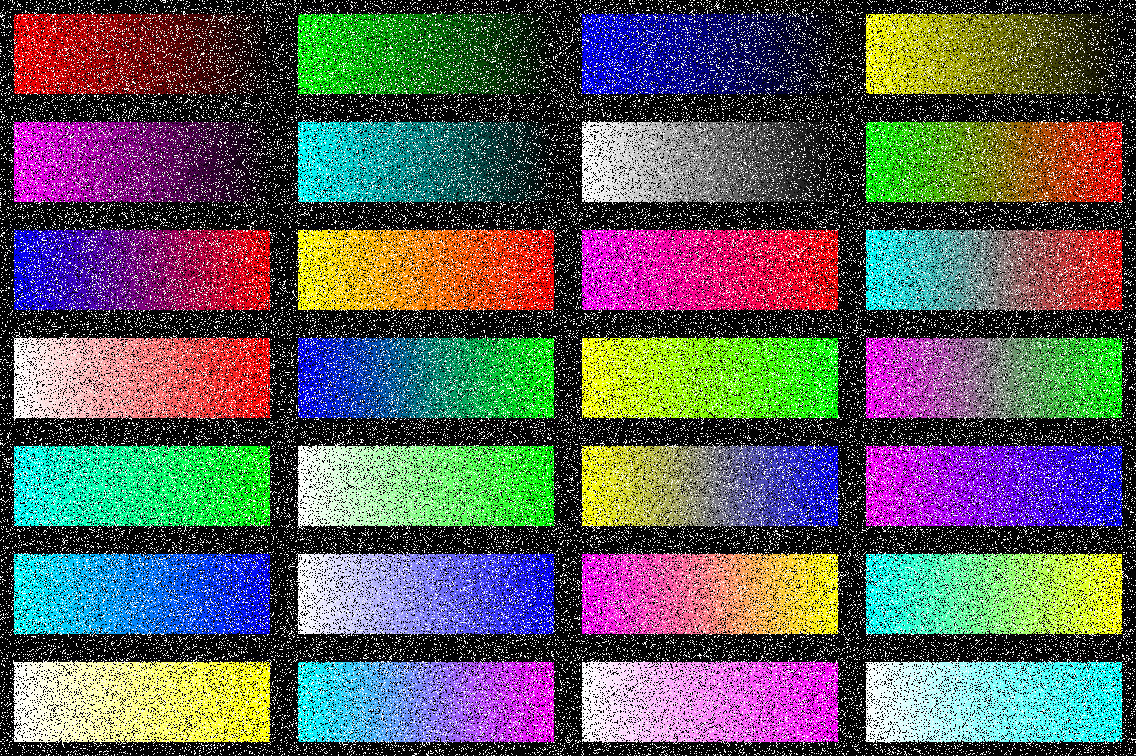

In [135]:
def salt_pepper_noise(img, speckles_per_pixel=.3, salt_pepper_ratio=.5, seed=[1,2,3]):
    w, h, c = img.shape
    print(img.shape)

    n_speckles = w*h*speckles_per_pixel
    n_salt     = int(n_speckles*salt_pepper_ratio)
    n_pepper   = int(n_speckles*(1-salt_pepper_ratio))

    gen = np.random.default_rng(seed)

    def rand_coords(n):
        return [(x % w, x // w) for x in gen.integers(0, w*h, n)]

    res = img.copy()
    
    for coord in rand_coords(n_salt):
        res[coord] = 255

    for coord in rand_coords(n_pepper):
        res[coord] = 0

    return res

display(Image.fromarray(np.array(salt_pepper_noise(ct_img), dtype=np.uint8)))